<a href="https://colab.research.google.com/github/sueoglu/gobi_gwas/blob/main/malena_sb/malena_sb_gwas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#setup
!pip install pandas-plink limix-lmm

In [2]:
#setup
import numpy as np
import pdb
from pandas_plink import read_plink
from limix_lmm import LMM
import pylab as plt
import os
import pandas as pd

In [3]:
#setup
import scipy
import scipy.stats as st

if not hasattr(scipy, 'dot'):
    scipy.dot = np.dot
if not hasattr(scipy, 'einsum'):
    scipy.einsum = np.einsum
if not hasattr(scipy, 'log'):
    scipy.log = np.log
if not hasattr(scipy, 'sign'):
    scipy.sign = np.sign
if not hasattr(scipy, 'sqrt'):
    scipy.sqrt = np.sqrt

In [4]:
#download data
!wget -O ALL.chr22_GRCh38.genotypes.20170504.zip  "https://www.dropbox.com/scl/fi/2j079oew31gwd2hzajlil/ALL.chr22_GRCh38.genotypes.20170504.zip?rlkey=7307x4sjq9lkvhwu3aivh5uut&e=1&dl=0"
!unzip -o -q ALL.chr22_GRCh38.genotypes.20170504.zip && rm ALL.chr22_GRCh38.genotypes.20170504.zip

--2026-02-13 11:39:09--  https://www.dropbox.com/scl/fi/2j079oew31gwd2hzajlil/ALL.chr22_GRCh38.genotypes.20170504.zip?rlkey=7307x4sjq9lkvhwu3aivh5uut&e=1&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc01d058c2aeb17cd433bd354739.dl.dropboxusercontent.com/cd/0/inline/C63oaDmVwS-ggJCvBkn8w-HQpRHrp5HGi2etExlifvl-jeESmc9o3u60C0HKlvBAiK2HrvXSgj71_22NAR4mpAfrjTu1mOSS10lzK3OWyE-TZCsJWvQFhn1LGYnTABizKQU/file# [following]
--2026-02-13 11:39:09--  https://uc01d058c2aeb17cd433bd354739.dl.dropboxusercontent.com/cd/0/inline/C63oaDmVwS-ggJCvBkn8w-HQpRHrp5HGi2etExlifvl-jeESmc9o3u60C0HKlvBAiK2HrvXSgj71_22NAR4mpAfrjTu1mOSS10lzK3OWyE-TZCsJWvQFhn1LGYnTABizKQU/file
Resolving uc01d058c2aeb17cd433bd354739.dl.dropboxusercontent.com (uc01d058c2aeb17cd433bd354739.dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:601

In [5]:
#load data
bfile = 'ALL.chr22_GRCh38.genotypes.20170504'
bim, fam, G = read_plink(bfile)

Mapping files: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]
/usr/local/lib/python3.12/dist-packages/pandera/_pandas_deprecated.py:146: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


In [6]:
print(G.shape[0])
print(G.shape[1])

109827
2504


# Preprocessing

In [7]:
#preprocessing
#remove indivs with lots of missing(NAN) values (5%)
Gp = G.compute()
fraction_of_missing_indivs = np.isnan(Gp).mean(axis=0) # average number of NA values across variants
keep_indivs = fraction_of_missing_indivs <0.05 #keep the ones with less than 5%

Gr = Gp[:, keep_indivs] #filter
fams = fam.iloc[keep_indivs].reset_index(drop=True) #locate the indiv to keep and repair the index


In [8]:
print(Gr.shape[0])
print(Gr.shape[1])

109827
2504


In [9]:
#preprocessing
#remove SNPs missing in many indivs (5%)
fraction_of_missing_SNPs = np.isnan(Gr).mean(axis=1) #average freq of snp across indivs
keep_SNPs = fraction_of_missing_SNPs <0.05 #keep the ones with less than 5%
Gg = Gr[keep_SNPs, :] #filter
bimr = bim.iloc[keep_SNPs].reset_index(drop=True) #locate SNPs to keep and repair the index

In [10]:
print(Gg.shape[0])
print(Gg.shape[1])

109804
2504


In [11]:
#preprocessing
#remove rare variants (maf<5%)
allele_freq = np.nanmean(Gg, axis=1)/2 #average snp freq across indivs, ignor NA
maf = np.minimum(allele_freq, 1-allele_freq) #find minor allele
keep_maf = maf >= 0.05 #keep snps with maf> 5%
Gm = Gg[keep_maf, :] #filter
bimr = bimr.iloc[keep_maf].reset_index(drop=True) #locate SNPs to keep and repair the index

In [12]:
print(Gm.shape[0])
print(Gm.shape[1])

109804
2504


In [13]:
#preprocessing
#remove duplicate SNPs (same position)
duplicate = bimr.duplicated(subset=['chrom', 'pos']) #check for duplicate chromosome and pos pairs (add boolean column "duplicate")
#Gp.compute_chunk_sizes()
Gd = Gm[~duplicate, :] #filter (keep first occ)
bimr = bimr.loc[~duplicate].reset_index(drop=True)

In [14]:
# load genotype matrix
X_real = Gd.T

In [15]:
print(Gd.shape[0])
print(Gd.shape[1])

109713
2504


# Phase 1: Phenotype Simulation


In [16]:
#earlier provided gwas code
def simulate_pheno(X, idx_caus, var_expl, direction=None):
    # Ensure that the number of causal variant indices matches the number of variances explained.
    assert len(idx_caus) == len(var_expl)

    # If no direction is provided, randomly assign a positive or negative direction for each causal variant.
    if direction is None:
        direction = 2. * (np.random.rand(len(idx_caus)) > 0.5) - 1.
    # Ensure that the number of directions matches the number of causal variant indices.
    assert len(idx_caus) == len(direction)

    # Compute the remaining variance after accounting for the variance explained by the causal variants.
    ve = 1 - var_expl.sum()
    # Ensure that the total variance explained by causal variants is less than 1.
    assert ve > 0, 'sum(var_expl) should be < 1'

    # Compute the effect sizes for the causal variants based on the variance they explain and their direction.
    beta = np.sqrt(var_expl) * direction

    # Extract the columns of X corresponding to the causal variants and standardize them.
    Xc = X[:, idx_caus]
    Xc = (Xc - Xc.mean(0)) / Xc.std(0)

    # Compute the genetic component of the phenotype.
    yg = Xc.dot(beta)[:, None]
    # Compute the noise component of the phenotype.
    yn = np.sqrt(ve) * np.random.randn(X.shape[0], 1)

    # Sum the genetic and noise components to get the simulated phenotype.
    y = yg + yn

    # Initialize the real effect sizes for all variants in X as zeros.
    beta_real = np.zeros(X.shape[1])
    # Update the real effect sizes for the causal variants.
    beta_real[idx_caus] = beta

    # Standardize the phenotypic values to have mean 0 and standard deviation 1.
    ystd = y.std()
    y = (y - y.mean()) / ystd
    # Adjust the real effect sizes accordingly after standardizing y.
    beta_real = beta_real / ystd

    return y, beta_real

In [17]:
#earlier provided
def qq_plot(p_values, figsize, title): #parameters changed
    """
    Create a QQ plot given a list of p-values.

    Parameters:
    - p_values: list of p-values
    - figsize: size of the plot
    - title: title for the plot
    """

    # Sort p-values
    observed = -np.log10(np.sort(p_values))
    expected = -np.log10(np.arange(1, len(p_values) + 1) / (len(p_values) + 2))

    # Create the QQ plot
    if figsize is not None: #added
      plt.figure(figsize=figsize) #added
    plt.scatter(expected, observed, marker='.')
    plt.plot([0, max(expected)], [0, max(expected)], color='red', linestyle='--')
    plt.xlabel('Expected -log10(P-value)')
    plt.ylabel('Observed -log10(P-value)')
    plt.title(title)

In [118]:
SEED = 42
rng = np.random.default_rng(SEED)
np.random.seed(SEED)

#earlier provided gwas code
#Vary parameters
n_causal = 50
h2 = 0.1

#10 causal SNPs
idx_caus = rng.choice(X_real.shape[1], size=n_causal, replace = False)
var_expl = np.repeat(h2/n_causal, n_causal)

y, beta_real = simulate_pheno(X_real, idx_caus, var_expl)

In [119]:
#earlier provided gwas code
# Perform genetic association testing
F = np.ones_like(y)
lmm = LMM(y, F)
lmm.process(X_real)
pv = lmm.getPv()
beta = lmm.getBetaSNP()
beta_ste = lmm.getBetaSNPste()

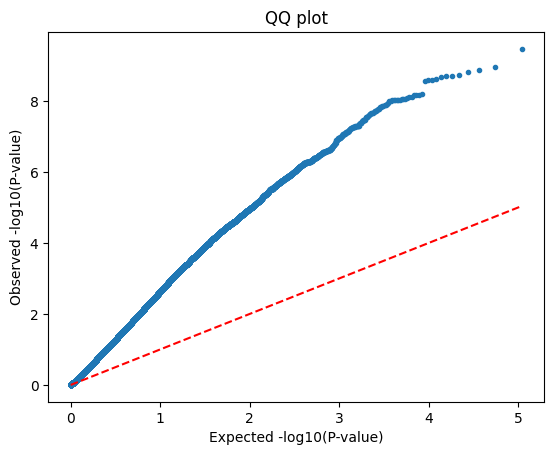

In [120]:
#earlier provided gwas code
qq_plot(pv, None, 'QQ plot')
plt.show()

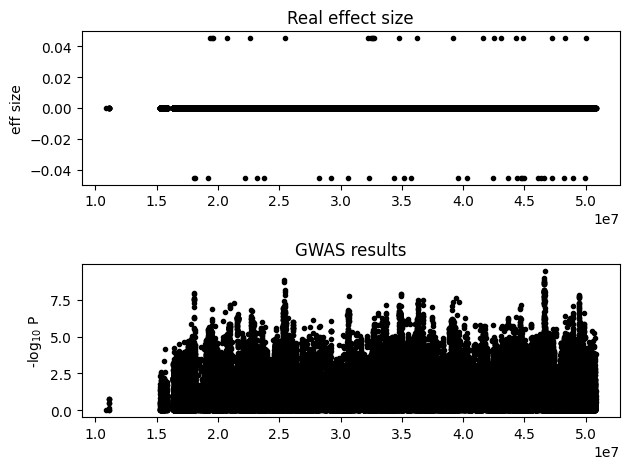

In [121]:
#earlier provided gwas code
# Plot ground truth and results
x = bimr['pos'].values
plt.subplot(211)
plt.title('Real effect size')
plt.plot(x, beta_real, '.k')
plt.ylabel('eff size')
plt.subplot(212)
plt.title('GWAS results')
plt.plot(x, -np.log10(pv), '.k')
plt.ylabel('-log$_{10}$ P')
plt.tight_layout()
plt.show()

# Phase 2: GWAS & Feature Selection

In [23]:
#cohort splitting, training: do GWAS, validation: evaluate PRS predictions oon independent data

from sklearn.model_selection import train_test_split #function from scikit-learn
#set indices of indivs in trainin(80%) and validations sets(20%), random-state ensures same split, reproducibility
training_set_idx, validation_set_idx = train_test_split(np.arange(X_real.shape[0]), test_size=0.2, random_state=0)
#subset the genotype matrix, use idx to split snps
X_training, X_validation = X_real[training_set_idx, :], X_real[validation_set_idx, :]
#subset the simulated phenotype vector for the split snps
y_training, y_validation = y[training_set_idx], y[validation_set_idx]

In [24]:
#GWAS analysis: for the training set

F_train = np.ones_like(y_training)
lmm_train = LMM(y_training, F_train)
lmm_train.process(X_training)
pv_train = lmm_train.getPv()
beta_train = lmm_train.getBetaSNP()
beta_ste_train = lmm_train.getBetaSNPste()

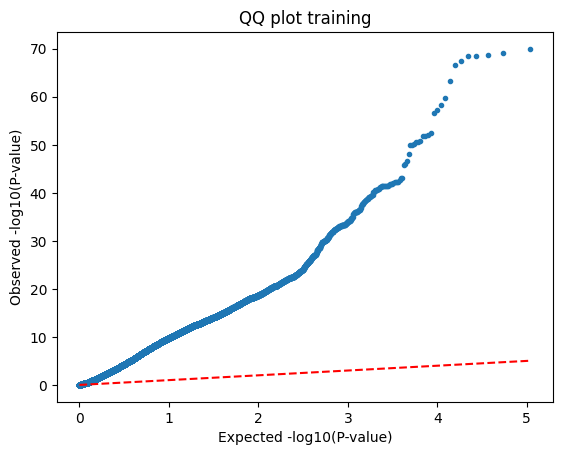

In [25]:
#earlier provided gwas code
qq_plot(pv_train, None, 'QQ plot training')
plt.show()

In [26]:
#Clumping: keep a representative SNP for high LD SNP groups to avoid redundant info
!apt-get install plink

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
plink is already the newest version (1.07+dfsg-4).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.


In [27]:
#prepare
#write plink file to clump gwas results with plink

#selesct trainig set and columns for plink
training_samples = fams.iloc[training_set_idx][['fid', 'iid']]
training_samples.to_csv('training_samples.txt', sep = ' ', index = False, header = False)
#selesct validation set and columns
validation_samples = fams.iloc[validation_set_idx][['fid', 'iid']]
validation_samples.to_csv('validation_samples.txt', sep = ' ', index = False, header = False)

#summary
gwas_df = pd.DataFrame({'SNP': bimr['snp'].values, 'CHR': bimr['chrom'].astype(int), 'BP': bimr['pos'].values, 'P': pv_train})
gwas_df.to_csv('gwas_training.txt', sep='\t', index=False)

In [28]:
#plink
#Prevention of Leakage
!plink --bfile ALL.chr22_GRCh38.genotypes.20170504 \
       --keep training_samples.txt \
       --clump gwas_train.txt \
       --clump-p1 1e-5 \
       --clump-r2 0.1 \
       --out clumped_train \
       --clump-verbose
#keep only training indivs
#only consider snps wiht pv < 1e-5
#clump based on threshold for LD (0.1)

/bin/bash: line 1: plink: command not found


In [29]:
#clumping results
clumped_train ...

SyntaxError: invalid syntax (ipython-input-140511702.py, line 2)

# Phase 3: Model Developement